Using device: mps
Found 9 classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total images: 19299

Starting training...



Epoch 1/15 | Train Loss: 1.5992 | Train Acc: 43.84% | Val Loss: 1.0970 | Val Acc: 58.78%


Epoch 2/15 | Train Loss: 1.2554 | Train Acc: 58.08% | Val Loss: 0.9946 | Val Acc: 65.13%


Epoch 3/15 | Train Loss: 1.0594 | Train Acc: 64.89% | Val Loss: 0.8641 | Val Acc: 69.66%


Epoch 4/15 | Train Loss: 0.9196 | Train Acc: 70.37% | Val Loss: 0.8115 | Val Acc: 70.49%


Epoch 5/15 | Train Loss: 0.8593 | Train Acc: 72.82% | Val Loss: 0.7376 | Val Acc: 74.84%


Epoch 6/15 | Train Loss: 0.7523 | Train Acc: 76.64% | Val Loss: 0.8156 | Val Acc: 72.94%


Epoch 7/15 | Train Loss: 0.7066 | Train Acc: 78.27% | Val Loss: 0.7100 | Val Acc: 75.26%


Epoch 8/15 | Train Loss: 0.6817 | Train Acc: 80.01% | Val Loss: 0.7477 | Val Acc: 74.71%


Epoch 9/15 | Train Loss: 0.6625 | Train Acc: 80.64% | Val Loss: 0.6881 | Val Acc: 77.02%


Epoch 10/15 | Train Loss: 0.6364 | Train Acc: 82.12% | Val Loss: 0.7206 | Val Acc: 78.89%


Epoch 11/15 | Train Loss: 0.5390 | Train Acc: 84.14% | Val Loss: 0.8189 | Val Acc: 76.85%


Epoch 12/15 | Train Loss: 0.5928 | Train Acc: 84.17% | Val Loss: 0.7667 | Val Acc: 78.09%


Epoch 13/15 | Train Loss: 0.5314 | Train Acc: 85.31% | Val Loss: 0.7691 | Val Acc: 78.82%


Epoch 14/15 | Train Loss: 0.5346 | Train Acc: 85.65% | Val Loss: 0.7748 | Val Acc: 78.71%


Epoch 15/15 | Train Loss: 0.4841 | Train Acc: 86.68% | Val Loss: 0.8120 | Val Acc: 78.61%

Training finished!



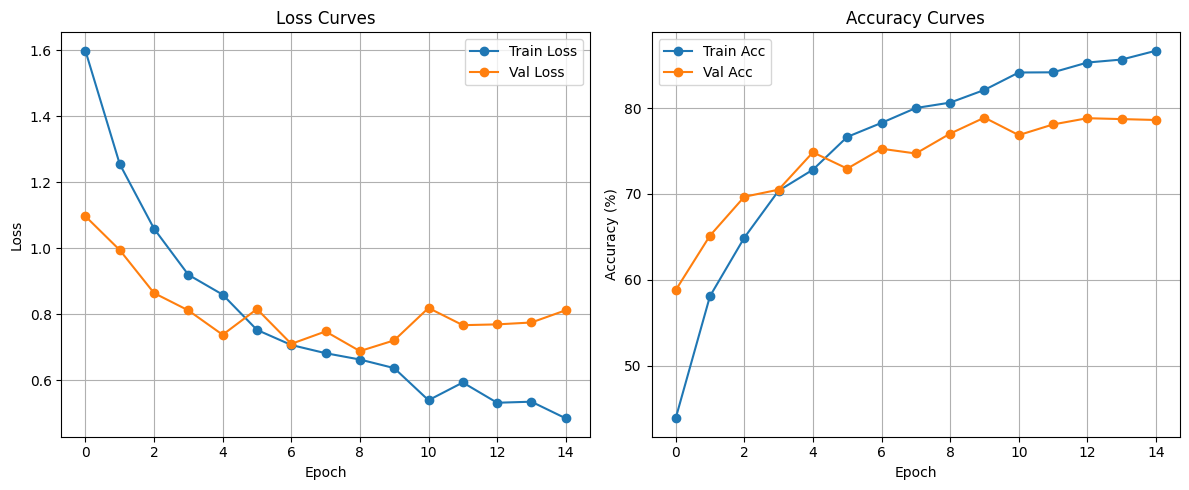

Running final test and collecting predictions...


Final Test Evaluation: 100%|██████████| 91/91 [00:28<00:00,  3.15it/s]



FINAL TEST RESULTS
Test Loss: 0.8243 | Test Accuracy: 78.04%


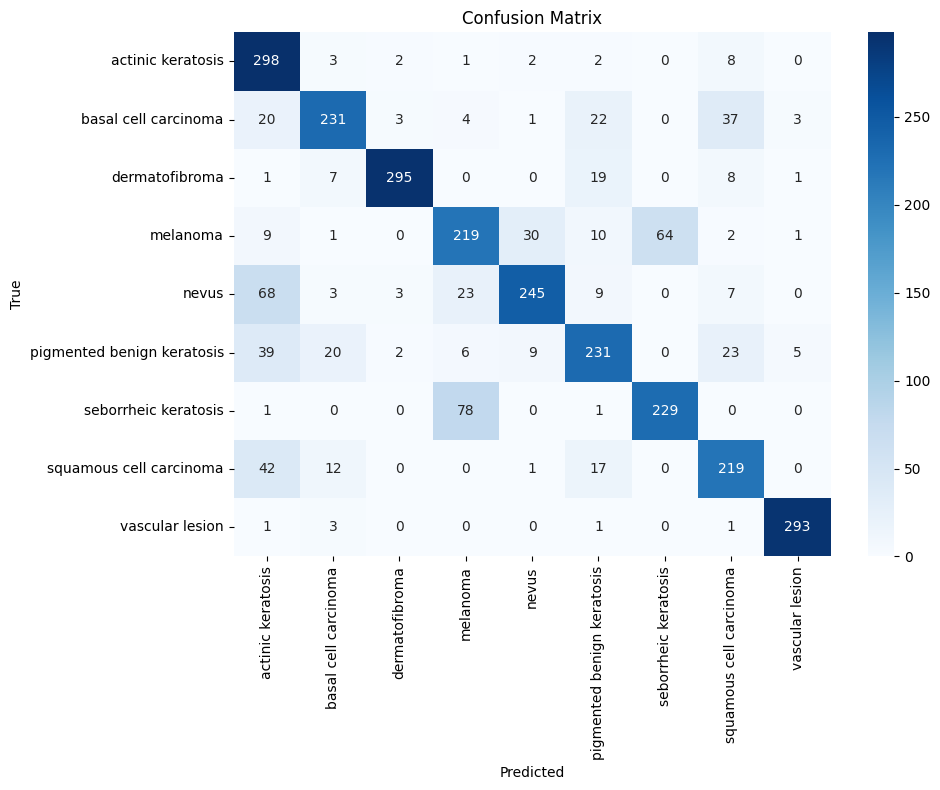


Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis     0.6221    0.9430    0.7497       316
      basal cell carcinoma     0.8250    0.7196    0.7687       321
            dermatofibroma     0.9672    0.8912    0.9277       331
                  melanoma     0.6616    0.6518    0.6567       336
                     nevus     0.8507    0.6844    0.7585       358
pigmented benign keratosis     0.7404    0.6896    0.7141       335
      seborrheic keratosis     0.7816    0.7411    0.7608       309
   squamous cell carcinoma     0.7180    0.7526    0.7349       291
           vascular lesion     0.9670    0.9799    0.9734       299

                  accuracy                         0.7804      2896
                 macro avg     0.7926    0.7837    0.7827      2896
              weighted avg     0.7928    0.7804    0.7811      2896



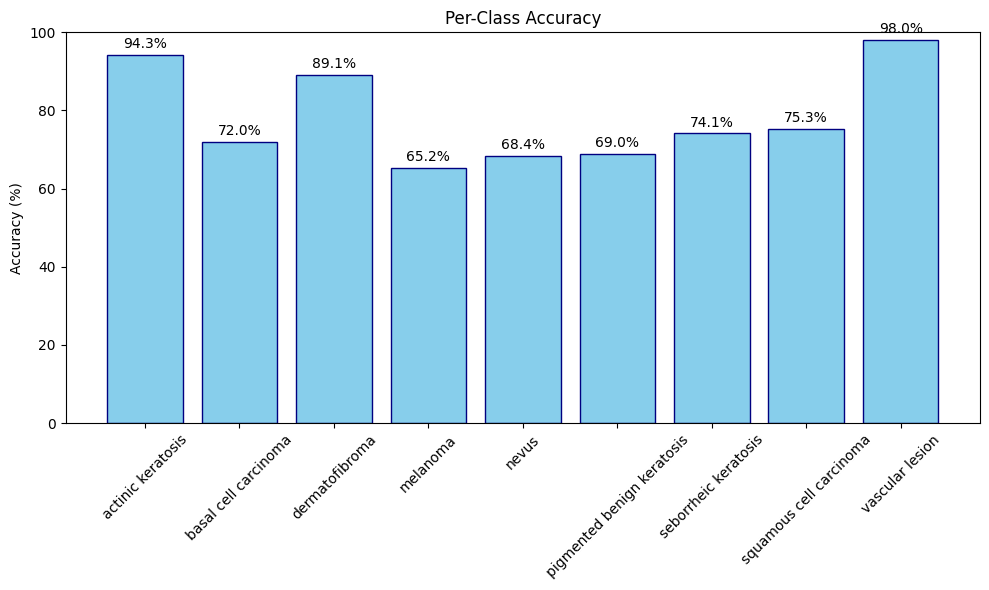

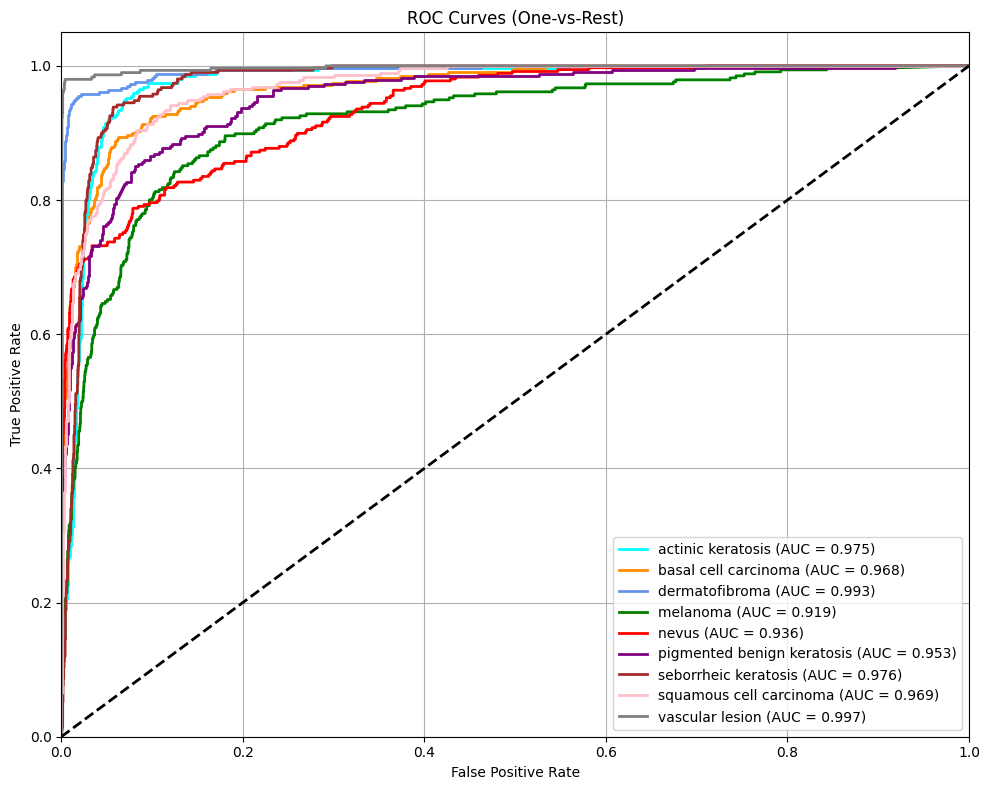

Macro AUC: 0.9652


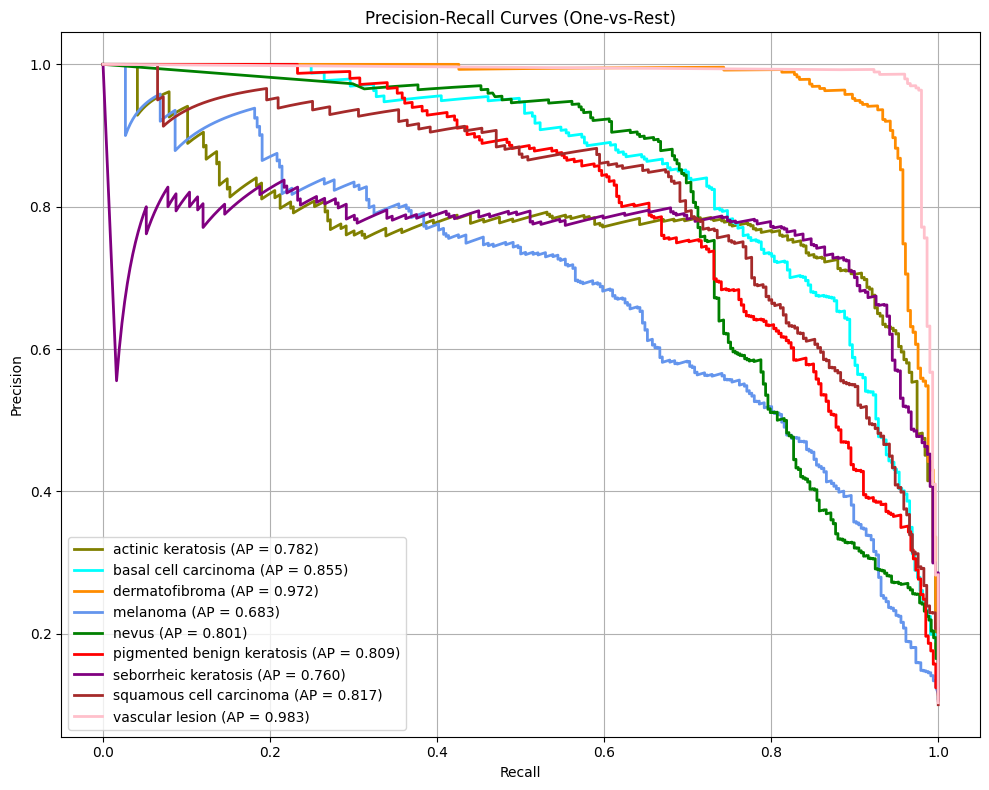


All evaluation plots generated successfully!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ==============================
# Configuration
# ==============================
dataset_path = 'dataset_2/Augmented_Train'
batch_size = 32
num_epochs = 15
learning_rate = 0.001

# Device
device = torch.device("mps")
print(f"Using device: {device}")

# ==============================
# Data Transforms & Dataset
# ==============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
print(f"Found {num_classes} classes: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")

# Train / Val / Test split (70% / 15% / 15%)
train_size = int(0.70 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# ==============================
# Model: VGG16 with custom classifier
# ==============================
model = models.vgg16(pretrained=True)

# Freeze feature layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# ==============================
# Metrics storage
# ==============================
train_losses, train_accuracies = [], []
val_losses,   val_accuracies   = [], []

print("\nStarting training...\n")

# ==============================
# Training Loop with tqdm progress bar
# ==============================
for epoch in range(num_epochs):
    # ---------------- Training ----------------
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct_train/total_train:.2f}%'
        })

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc  = 100. * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # ---------------- Validation ----------------
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val  ]", leave=False)

    with torch.no_grad():
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

            val_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_val/total_val:.2f}%'
            })

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc  = 100. * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.2f}%")

print("\nTraining finished!\n")

# ==============================
# Plot Training & Validation Curves
# ==============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses,   label='Val Loss',   marker='o')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc', marker='o')
plt.plot(val_accuracies,   label='Val Acc',   marker='o')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ==============================
# Final Test Evaluation + All Advanced Plots
# ==============================
model.eval()
all_preds = []
all_labels = []
all_probs = []

test_loss = 0.0
correct_test = 0
total_test = 0

print("Running final test and collecting predictions...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Test Evaluation"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

final_test_loss = test_loss / len(test_loader)
final_test_acc = 100. * correct_test / total_test

print(f"\n{'='*60}")
print(f"FINAL TEST RESULTS")
print(f"Test Loss: {final_test_loss:.4f} | Test Accuracy: {final_test_acc:.2f}%")
print(f"{'='*60}")

# ==============================
# 1. Confusion Matrix
# ==============================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ==============================
# 2. Classification Report
# ==============================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, digits=4))

# ==============================
# 3. Per-class Accuracy Bar Chart
# ==============================
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
plt.figure(figsize=(10, 6))
bars = plt.bar(full_dataset.classes, per_class_acc, color='skyblue', edgecolor='navy')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# ==============================
# 4. ROC Curve & AUC (One-vs-Rest)
# ==============================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels
y_true_bin = label_binarize(all_labels, classes=range(num_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{full_dataset.classes[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print macro and weighted AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro AUC: {macro_auc:.4f}")

# ==============================
# 5. Precision-Recall Curve (One-vs-Rest)
# ==============================
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f'{full_dataset.classes[i]} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nAll evaluation plots generated successfully!")